<a href="https://colab.research.google.com/github/CoderAPS/neural_nets/blob/main/cats_dogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import RandomFlip, RandomRotation, Rescaling, GlobalAveragePooling2D
from keras.layers import Dense, Dropout


In [3]:
# Download and extract a zip file containing the images

_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)



68606236/68606236 [==============================] - 2s 0us/step


In [4]:
# create a tf.data.Dataset for training and validation using the tf.keras.utils.image_dataset_from_directory utility

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [ ]:
i = 0
for data, labels in train_dataset:
    print(f'Batch num: {i}')
    print(data.shape)
    print(labels.shape)
    i += 1

Batch num: 0
(32, 160, 160, 3)
(32,)
Batch num: 1
(32, 160, 160, 3)
(32,)
Batch num: 2
(32, 160, 160, 3)
(32,)
Batch num: 3
(32, 160, 160, 3)
(32,)
Batch num: 4
(32, 160, 160, 3)
(32,)
Batch num: 5
(32, 160, 160, 3)
(32,)
Batch num: 6
(32, 160, 160, 3)
(32,)
Batch num: 7
(32, 160, 160, 3)
(32,)
Batch num: 8
(32, 160, 160, 3)
(32,)
Batch num: 9
(32, 160, 160, 3)
(32,)
Batch num: 10
(32, 160, 160, 3)
(32,)
Batch num: 11
(32, 160, 160, 3)
(32,)
Batch num: 12
(32, 160, 160, 3)
(32,)
Batch num: 13
(32, 160, 160, 3)
(32,)
Batch num: 14
(32, 160, 160, 3)
(32,)
Batch num: 15
(32, 160, 160, 3)
(32,)
Batch num: 16
(32, 160, 160, 3)
(32,)
Batch num: 17
(32, 160, 160, 3)
(32,)
Batch num: 18
(32, 160, 160, 3)
(32,)
Batch num: 19
(32, 160, 160, 3)
(32,)
Batch num: 20
(32, 160, 160, 3)
(32,)
Batch num: 21
(32, 160, 160, 3)
(32,)
Batch num: 22
(32, 160, 160, 3)
(32,)
Batch num: 23
(32, 160, 160, 3)
(32,)
Batch num: 24
(32, 160, 160, 3)
(32,)
Batch num: 25
(32, 160, 160, 3)
(32,)
Batch num: 26
(32, 160

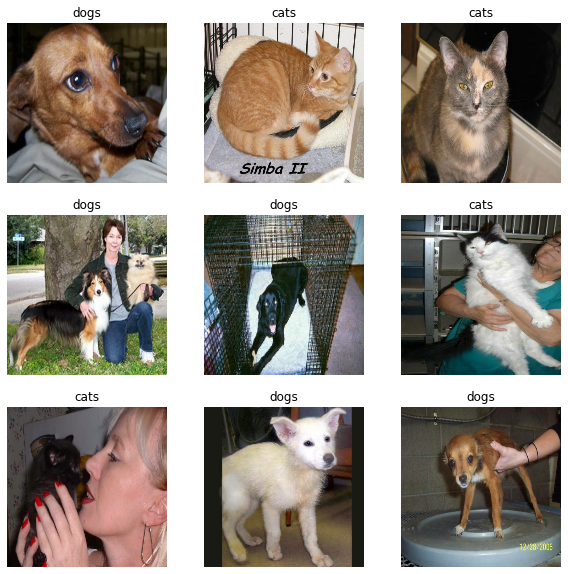

In [5]:
# Load some images from train_dataset
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [6]:
# create a test dataset from validation_dataset
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [7]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 26
Number of test batches: 6


In [ ]:
for data,label in test_dataset:
  print(data.shape)
  print(label.shape)

(32, 160, 160, 3)
(32,)
(32, 160, 160, 3)
(32,)
(32, 160, 160, 3)
(32,)
(32, 160, 160, 3)
(32,)
(32, 160, 160, 3)
(32,)
(32, 160, 160, 3)
(32,)


In [8]:
# Configure the dataset for performance: Use buffered prefetching to load images from disk 
# without having I/O become blocking

AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [ ]:
# Setup model ==============================================================================>

In [9]:
# Create the base model from the pre-trained model MobileNet V2
# This is pre-trained on the ImageNet dataset, a large dataset 
# consisting of 1.4M images and 1000 classes.
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9406464/9406464 [==============================] - 0s 0us/step


In [10]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))


Number of layers in the base model:  154


In [36]:

def create_model(learning_rate, base_model_trainable = False):

  # for feature extraction freeze the entire base_model
  if base_model_trainable == False:
    base_model.trainable = base_model_trainable

  # for transfer learning train the top ~ 54 layers of base_model (and freeze the bottom 100 layers)
  # along with classifier layer
  if base_model_trainable:
    # unfreeze base_model for training
    base_model.trainable = True

    # Fine-tune from this layer onwards
    fine_tune_at = 100

    # Freeze all the layers before the `fine_tune_at` layer
    for layer in base_model.layers[:fine_tune_at]:
      layer.trainable = False


  inputs = tf.keras.Input(shape=(160, 160, 3))
  
  # add image augmentation layers
  data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2)])

  augmentation_layer = data_augmentation(inputs)

  # preprocess image for base_model
  processed_data = tf.keras.applications.mobilenet_v2.preprocess_input(augmentation_layer)

  # add base_model
  base_model_layer = base_model(processed_data,training=False)

  # average over the spatial 5x5 spatial locations, using a 
  # GlobalAveragePooling2D layer to convert the features to a single 1280-element vector per image.
  layer_a = GlobalAveragePooling2D()(base_model_layer)

  # Add a dropout layer
  layer_b = Dropout(0.2)(layer_a)

  # Add a classification layer: don't need an activation function here because this prediction 
  # will be treated as a logit, or a raw prediction value. Positive numbers predict class 1, 
  # negative numbers predict class 0.
  outputs = Dense(1)(layer_b)

  model = keras.Model(inputs,outputs)

  #base_learning_rate = 0.0001
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
  
  return model

In [37]:
learning_rate=0.0001
model_obj = create_model(learning_rate)

In [38]:
loss0,accuracy0 = model_obj.evaluate(validation_dataset)

26/26 [==============================] - 2s 33ms/step - loss: 0.4841 - accuracy: 0.7983


In [39]:
print(f'Initial loss: {loss0:.3f}')
print(f'Initial accuracy: {accuracy0:.3f}')

Initial loss: 0.484
Initial accuracy: 0.798


In [40]:
def evaluate_model(model,epochs,fine_tunning=False,initial_epochs=0):
  model.summary()

  history = model.fit(train_dataset,epochs=epochs,
                      initial_epoch = initial_epochs,
                      validation_data=validation_dataset,
                      verbose=False)

  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  plt.figure(figsize=(12,4))
  plt.subplot(1, 2, 1)
  plt.plot(acc, label='Training Accuracy')
  plt.plot(val_acc, label='Validation Accuracy')

  if fine_tunning:
    plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
    
  plt.legend(loc='lower right')
  plt.ylabel('Accuracy')
  plt.ylim([min(plt.ylim()),1])
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(loss, label='Training Loss')
  plt.plot(val_loss, label='Validation Loss')

  if fine_tunning:
    plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
    
  plt.legend(loc='upper right')
  plt.ylabel('Cross Entropy')
  plt.ylim([0,1.0])
  plt.title('Training and Validation Loss')
  plt.xlabel('epoch')
  plt.show()

  final_train_accuracy = history.history['accuracy'][-1]
  final_validation_accuracy = history.history['val_accuracy'][-1]

  final_train_loss = history.history['loss'][-1]
  final_validation_loss = history.history['val_loss'][-1]

  print(f'Training accuracy: {final_train_accuracy:.3f}\tTraining loss: {final_train_loss:.3f}')
  print(f'Validation accuracy: {final_validation_accuracy:.3f}\tTraining loss: {final_validation_loss:.3f}')

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential_3 (Sequential)   (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv_3 (TFOpLamb  (None, 160, 160, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_3 (TFOpLam  (None, 160, 160, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                           

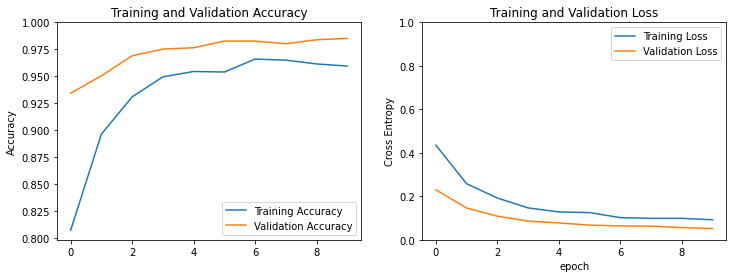

Training accuracy: 0.960	Training loss: 0.092
Validation accuracy: 0.985	Training loss: 0.052


In [41]:
# Use pretrained base_model for feature extraction
# the entire base_model is frozen and thus not trainable
evaluate_model(model_obj,10)

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential_4 (Sequential)   (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv_4 (TFOpLamb  (None, 160, 160, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_4 (TFOpLam  (None, 160, 160, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                           

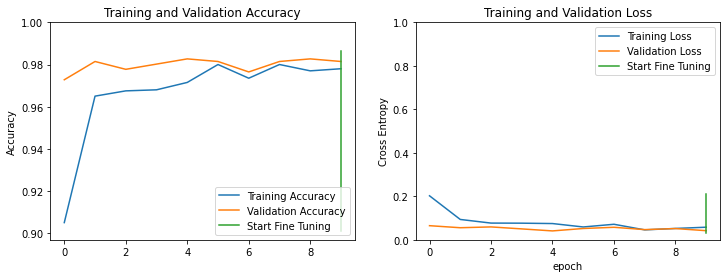

Training accuracy: 0.978	Training loss: 0.058
Validation accuracy: 0.981	Training loss: 0.042


In [43]:
# fine tune model by unfreezing top ~ 54 layers of base_model for training
# note: this is not a continuation of previous training (when doing feature extraction)
model_obj = create_model(learning_rate/10,True)
evaluate_model(model_obj,20,True,10)

In [44]:
test_lost,test_accuracy = model_obj.evaluate(test_dataset)

6/6 [==============================] - 0s 37ms/step - loss: 0.0592 - accuracy: 0.9740


In [45]:
print(f'Test accuracy is: {test_accuracy:.3f}\nTest loss is: {test_lost:0.3f}')

Test accuracy is: 0.974
Test loss is: 0.059
